## Import Libraries 

In [1]:
import os
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.functional as F
import torch.nn as nn
import torchvision
import torchvision.models as models
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import IPython.display as ipd
import torchaudio
import librosa
import librosa.display
import functools
import copy
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Read the ESC csv file 

In [3]:
df = pd.read_csv('ESC-50/meta/esc50.csv')
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


### Map targets to their classes 

In [4]:
class_dict = {}

for target in df['target'].unique():
    class_dict[target] = df[df['target'] == target]['category'].unique()[0]
    
import collections
class_dict = dict(collections.OrderedDict(sorted(class_dict.items())))
class_dict

{0: 'dog',
 1: 'rooster',
 2: 'pig',
 3: 'cow',
 4: 'frog',
 5: 'cat',
 6: 'hen',
 7: 'insects',
 8: 'sheep',
 9: 'crow',
 10: 'rain',
 11: 'sea_waves',
 12: 'crackling_fire',
 13: 'crickets',
 14: 'chirping_birds',
 15: 'water_drops',
 16: 'wind',
 17: 'pouring_water',
 18: 'toilet_flush',
 19: 'thunderstorm',
 20: 'crying_baby',
 21: 'sneezing',
 22: 'clapping',
 23: 'breathing',
 24: 'coughing',
 25: 'footsteps',
 26: 'laughing',
 27: 'brushing_teeth',
 28: 'snoring',
 29: 'drinking_sipping',
 30: 'door_wood_knock',
 31: 'mouse_click',
 32: 'keyboard_typing',
 33: 'door_wood_creaks',
 34: 'can_opening',
 35: 'washing_machine',
 36: 'vacuum_cleaner',
 37: 'clock_alarm',
 38: 'clock_tick',
 39: 'glass_breaking',
 40: 'helicopter',
 41: 'chainsaw',
 42: 'siren',
 43: 'car_horn',
 44: 'engine',
 45: 'train',
 46: 'church_bells',
 47: 'airplane',
 48: 'fireworks',
 49: 'hand_saw'}

## Lets hear an example audio 

In [48]:
example1 = np.random.choice(glob('ESC-50/audio/*'))
example1

'ESC-50/audio\\5-188655-A-10.wav'

In [49]:
class_dict[int(example1.split('-')[-1].replace('.wav', ''))]

'rain'

In [50]:
ipd.Audio(example1)

## Load the audio file using Librosa 

(220500,) 44100


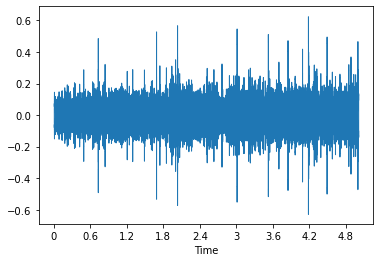

In [51]:
# Visualize waveform in the time domain
file = example1
wav, sr = librosa.load(file, sr = None)
print(wav.shape, sr)
librosa.display.waveshow(wav, sr = sr)

##  Create spectrogram using Librosa

(128, 431)


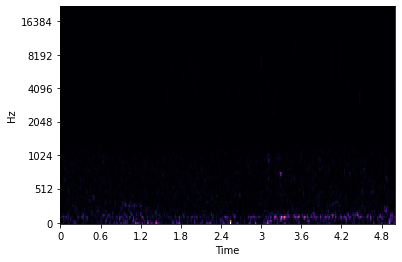

In [52]:
# Display mel-scaled spectrogram.
spectrogram = librosa.feature.melspectrogram(y = wav, sr = sr, n_fft = 2048, hop_length = 512, win_length = None)
print(spectrogram.shape)
librosa.display.specshow(spectrogram, sr = sr, x_axis = 'time', y_axis = 'mel')

(128, 431)


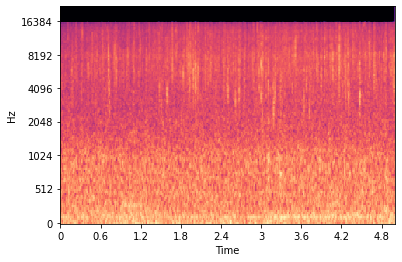

In [53]:
# Convert the spectrogram to a logarithmic scale
log_spectrogram = librosa.power_to_db(spectrogram, ref = np.max)
print(log_spectrogram.shape)
spec = librosa.display.specshow(log_spectrogram, sr = sr, x_axis = 'time', y_axis = 'mel')
plt.savefig('rain.png')

In [12]:
# normalize using z score normalization and scale using min-max scaling so its values lie between 0 and 255.
def spec_to_image(spec, eps = 1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return np.stack([spec_scaled, spec_scaled, spec_scaled], axis = 2)

## PyTorch Dataset for ESC  

In [13]:
class ECS50dataset(Dataset):
    
    def __init__(self, file_paths):
        self.file_paths = file_paths
        self.labels = [int(x.split('-')[-1].replace('.wav', '')) for x in file_paths]
        self.transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    @functools.lru_cache(maxsize = 2000)
    def __getitem__(self, idx):
        file = self.file_paths[idx]
        audio_tensor, sample_rate = librosa.load(file, sr = None)
        spectrogram = librosa.feature.melspectrogram(audio_tensor, sr = sample_rate)
        log_spectrogram = librosa.power_to_db(spectrogram, ref = np.max)
        image = spec_to_image(log_spectrogram)
        return (self.transforms(image), torch.tensor(self.labels[idx], dtype = torch.long))
    
    def __len__(self):
        return len(self.file_paths)

In [14]:
df_files = pd.DataFrame({'File': glob('ESC-50/audio/*'),
                       'Label': [int(x.split('-')[-1].replace('.wav', '')) for x in glob('ESC-50/audio/*')]})
df_files.head(10)

,File,Label
0,ESC-50/audio\1-100032-A-0.wav,0
1,ESC-50/audio\1-100038-A-14.wav,14
2,ESC-50/audio\1-100210-A-36.wav,36
3,ESC-50/audio\1-100210-B-36.wav,36
4,ESC-50/audio\1-101296-A-19.wav,19
5,ESC-50/audio\1-101296-B-19.wav,19
6,ESC-50/audio\1-101336-A-30.wav,30
7,ESC-50/audio\1-101404-A-34.wav,34
8,ESC-50/audio\1-103298-A-9.wav,9
9,ESC-50/audio\1-103995-A-30.wav,30


### Split the files into Train and Validation splits 

In [15]:
from sklearn.model_selection import train_test_split

train_split, val_split = train_test_split(df_files['File'], test_size = 0.25, stratify = df_files['Label'], random_state = 121)

### Create dataset objects and dataloaders 

In [16]:
train_dataset = ECS50dataset(train_split.to_list())
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers = 0)

val_dataset = ECS50dataset(val_split.to_list())
val_dataloader = DataLoader(val_dataset, batch_size = 32, shuffle = False, num_workers = 0)

## Pretrained Resnet50

In [17]:
resnet50 = models.resnet50(pretrained = True)
for param in resnet50.parameters():
    param.requires_grad = False

in_features = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
                nn.Dropout(p = 0.3),
                nn.Linear(in_features, 50)
            )

### PyTorch learning rate finder 

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.58E-03


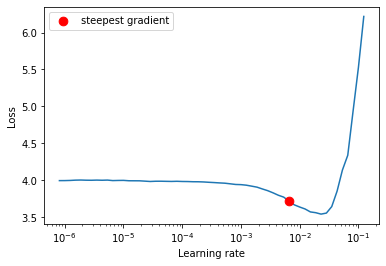

In [18]:
from torch_lr_finder import LRFinder

criterion = nn.CrossEntropyLoss(label_smoothing = 0.05)
optimizer = torch.optim.Adam(resnet50.parameters(), lr = 1e-7, weight_decay = 1e-2)
lr_finder = LRFinder(resnet50, optimizer, criterion, device = "cuda")
lr_finder.range_test(train_dataloader, end_lr = 100, num_iter = 100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

### Declare loss, optimizer and learning rate scheduler 

In [21]:
criterion = nn.CrossEntropyLoss(label_smoothing = 0.05)

optimizer = torch.optim.Adam(resnet50.parameters(), lr = 6.58E-03)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience = 3, mode = 'min', verbose = True)

### Function to train model 

In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    for epoch in range(1, num_epochs + 1):
        
        print(f'Epoch {epoch}/{num_epochs}')
        
        train_loss, train_acc, val_loss, val_acc = [], 0, [], 0
        
        train_loop = tqdm(train_dataloader, total = len(train_dataloader), position = 0, leave = True)
        
        model.train()
        for x, y in train_loop:
            x = x.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()
            
            output = model(x)
            preds = torch.argmax(output, dim = 1)
            loss = criterion(output, y)

            train_loss.append(loss.item())
            train_acc += torch.sum(preds == y)
            
            loss.backward()
            optimizer.step()
            
            train_loop.set_postfix(train_loss = np.mean(train_loss))
            
        train_loss = np.mean(train_loss)
        train_acc = train_acc / len(train_dataset)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        print(f'Train Loss : {train_loss:.4f}, Train Accuracy : {train_acc * 100:.2f}%')
        
        val_loop = tqdm(val_dataloader, total = len(val_dataloader), position = 0, leave = True)
        
        model.eval()
        with torch.no_grad():
            for x, y in val_loop:
                x = x.to(device)
                y = y.to(device)
                
                output = model(x)
                preds = torch.argmax(output, dim = 1)
                loss = criterion(output, y)

                val_loss.append(loss.item())
                val_acc += torch.sum(preds == y)
                
                val_loop.set_postfix(val_loss = np.mean(val_loss))
                
            val_loss = np.mean(val_loss)
            val_acc = val_acc / len(val_dataset)
            
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            
            scheduler.step(val_loss)
            
            print(f'Validation Loss : {val_loss:.4f}, Validation Accuracy : {val_acc * 100:.2f}%')
            
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        print('------------------------------------------------------------------\n')
            
    print(f'Training complete, Best Accuracy : {best_acc * 100:.2f}%')
    model.load_state_dict(best_model_wts)
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies

### Train Resnet50 for 10 epochs 

In [23]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(resnet50.to(device), criterion, optimizer, scheduler, 10)

Epoch 1/10


100%|█████████████████████████████████████████████████████████████████| 24/24 [00:18<00:00,  1.28it/s, train_loss=5.19]


Train Loss : 5.1926, Train Accuracy : 17.27%


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:25<00:00,  1.62s/it, val_loss=3.96]


Validation Loss : 3.9566, Validation Accuracy : 25.80%
------------------------------------------------------------------

Epoch 2/10


100%|█████████████████████████████████████████████████████████████████| 24/24 [00:18<00:00,  1.28it/s, train_loss=2.17]


Train Loss : 2.1695, Train Accuracy : 51.80%


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.66it/s, val_loss=2.87]


Validation Loss : 2.8702, Validation Accuracy : 34.20%
------------------------------------------------------------------

Epoch 3/10


100%|█████████████████████████████████████████████████████████████████| 24/24 [00:18<00:00,  1.27it/s, train_loss=1.46]


Train Loss : 1.4632, Train Accuracy : 69.53%


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.66it/s, val_loss=2.3]


Validation Loss : 2.3008, Validation Accuracy : 45.20%
------------------------------------------------------------------

Epoch 4/10


100%|█████████████████████████████████████████████████████████████████| 24/24 [00:18<00:00,  1.28it/s, train_loss=1.32]


Train Loss : 1.3241, Train Accuracy : 73.13%


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.66it/s, val_loss=1.8]


Validation Loss : 1.7967, Validation Accuracy : 62.00%
------------------------------------------------------------------

Epoch 5/10


100%|█████████████████████████████████████████████████████████████████| 24/24 [00:18<00:00,  1.28it/s, train_loss=1.22]


Train Loss : 1.2193, Train Accuracy : 75.07%


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.67it/s, val_loss=1.72]


Validation Loss : 1.7226, Validation Accuracy : 61.60%
------------------------------------------------------------------

Epoch 6/10


100%|█████████████████████████████████████████████████████████████████| 24/24 [00:18<00:00,  1.28it/s, train_loss=1.09]


Train Loss : 1.0898, Train Accuracy : 81.00%


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.68it/s, val_loss=1.59]


Validation Loss : 1.5935, Validation Accuracy : 65.60%
------------------------------------------------------------------

Epoch 7/10


100%|█████████████████████████████████████████████████████████████████| 24/24 [00:18<00:00,  1.28it/s, train_loss=1.05]


Train Loss : 1.0517, Train Accuracy : 81.80%


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.68it/s, val_loss=1.83]


Validation Loss : 1.8276, Validation Accuracy : 62.40%
------------------------------------------------------------------

Epoch 8/10


100%|█████████████████████████████████████████████████████████████████| 24/24 [00:19<00:00,  1.26it/s, train_loss=1.06]


Train Loss : 1.0550, Train Accuracy : 83.73%


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.67it/s, val_loss=1.63]


Validation Loss : 1.6254, Validation Accuracy : 64.60%
------------------------------------------------------------------

Epoch 9/10


100%|█████████████████████████████████████████████████████████████████| 24/24 [00:18<00:00,  1.28it/s, train_loss=1.03]


Train Loss : 1.0342, Train Accuracy : 83.33%


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.68it/s, val_loss=1.67]


Validation Loss : 1.6717, Validation Accuracy : 66.20%
------------------------------------------------------------------

Epoch 10/10


100%|████████████████████████████████████████████████████████████████| 24/24 [00:18<00:00,  1.28it/s, train_loss=0.996]


Train Loss : 0.9960, Train Accuracy : 85.33%


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.67it/s, val_loss=1.75]

Epoch    10: reducing learning rate of group 0 to 6.5800e-04.
Validation Loss : 1.7463, Validation Accuracy : 66.60%
------------------------------------------------------------------

Training complete, Best Accuracy : 66.60%


## Let's test the model with a random sample from validation dataset 

In [42]:
i = np.random.randint(1, 500)
y = val_dataset[i][1].item()
X = val_dataset[i][0].unsqueeze(0).to(device)
ipd.Audio(val_dataset.file_paths[i])

In [43]:
class_dict[torch.argmax(resnet50(X)[0]).item()], class_dict[y]

('cow', 'cow')